# Homework 5 - Independent Component Analysis

Brennan McFarland  
bfm21

In this assignment I implement gradient-based Independent Component Analysis for Blind Source Separation and apply it to the cocktail party problem.  My algorithm, implemented in the bsslib.py file, applies the BSS algorithm to a matrix of unseparated data from mixed sources and performs gradient descent on the mixing matrix until convergence, which it then uses to recover the original source data.  I first demonstrate this algorithm on a randomly generated Laplacian matrix, and then use it to separate audio files from mixed soundtracks.

### Loading the Data

I will apply the BSS algorithm to a mixture of the following speech and classical music sound files:

In [1]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('data/bach.wav')
_, dataSpeech = wavfile.read('data/speech.wav')

### Normalizing the Data

This function converts the sound data to a form we can more easily manipulate by normalizing the soundtracks as numpy arrays:

In [2]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

gtruthS = audionorm([dataBach, dataSpeech])

### Mixing Audio

Here we apply a simple mixing function, mixing the audio data via multiplying the source soundtracks (in a 2xn matrix, 2 for the number of soundtracks and n for the number of data points in the audio clip) by a random mixing matrix transformation.  This produces another 2xn matrix with two new soundtracks representing the mixed sounds.  We then display the data output along with our coordinate axes for the mixing matrix and save the mixed audio to their respective files.

In [3]:
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')

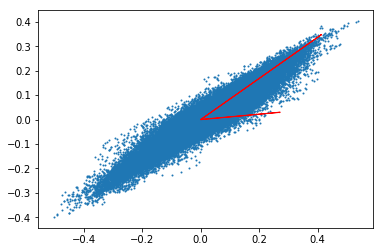

In [5]:
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [6]:
wavfile.write('data/mixedTrackA.wav', srate, X[0])
wavfile.write('data/mixedTrackB.wav', srate, X[1])

### Optimization Functions

For this implementation of BSS we are assuming no noise, and therefore we can represent the unmixing process by the formula  
$x = As$  
where x is the mixed soundtracks, A is the mixing matrix and s is the original sources/signals.  Thus unmixing the signals/sources is as simple as matrix multiplication with the inverse of the mixing matrix:  
$s = A^{-1}x$
The algorithm functions by estimating A and updating it in the direction of our estimate's gradient.  The gradient is calculated according to the equation  
$gradA = -A(zs^{T} + I)$  
where $s^{T}$ is the transpose of our signal matrix and z is the matrix composed of $z_{i}=\frac{d}{ds}log((P(s_{i}))$.  
Since this is equivalent to $\frac{d}{ds}log(e^{|\frac{-s_{i}}{\lambda}|^{q}}) = -|\frac{s_{i}}{\lambda}|^{q-1}$,  
and q=1 since we are assuming a Laplacian distribution so $z = -sign(s)$

In [7]:
from bsslib import bss

### Verifying on Synthetic Data

First, we verify that the algorithm works by applying it to random data.  Note that as the algorithm assumes a Laplacian distribution, the test data must also follow this distribution and this is taken into account when generating the matrix.  Also, every few iterations of the gradient descent the norm and mixing matrix is printed to show its convergence.  Since the gradient of the mixing matrix is indicative of the slope of the problem space, the norm of the gradient is indicative of the error of our mixing matrix estimation.  This is useful both for a stopping criterion, as the algorithm halts once the gradient's norm falls below a certain threshold, and for indicating the progress of convergence to the ground truth mixing matrix.  Thus, in addition to being printed every few iterations, I chose to plot its decrease over time to visually indicate convergence.

gradient norm:  33359.805961599646
mixing matrix:  [[1508.24306668   75.50178602]
 [  34.0804321  2975.91560894]]
gradient norm:  4152.100970149498
mixing matrix:  [[13355.61462226  1261.29570312]
 [-1727.93467006 26421.7690639 ]]
gradient norm:  1825.4194380652402
mixing matrix:  [[14589.14336019  2681.11510664]
 [-4416.52696757 28928.52876344]]
gradient norm:  3072.624073056142
mixing matrix:  [[14081.6554545   4862.85098572]
 [-8797.01659367 28053.70977653]]
gradient norm:  3956.140898560963
mixing matrix:  [[ 12445.37065224   7668.94322759]
 [-14548.81777324  25025.80259805]]
gradient norm:  1876.9828831482612
mixing matrix:  [[ 10725.23421335   9474.9814566 ]
 [-18257.32198396  21683.5712872 ]]
gradient norm:  376.24550748814886
mixing matrix:  [[ 10019.62233902  10088.18875249]
 [-19441.08034072  20260.08147423]]


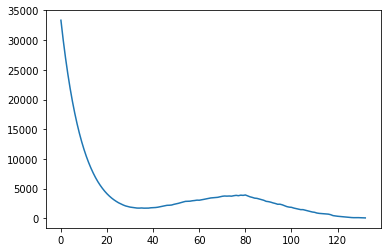

In [8]:
from bsslib import syntheticDataGenerate

# quantity of data points
nsamples = 10000
# specific mixing matrix (for illustration purpose)
verifyA = np.asarray([[-1, 1],[2, 2]])
# generate synthetic data
synthData = syntheticDataGenerate(verifyA, nsamples)
# do optimization with bss function
estimateA, recoverData = bss(synthData)

And note how well our estimated mixing matrix converges to the ground truth value as compared below:

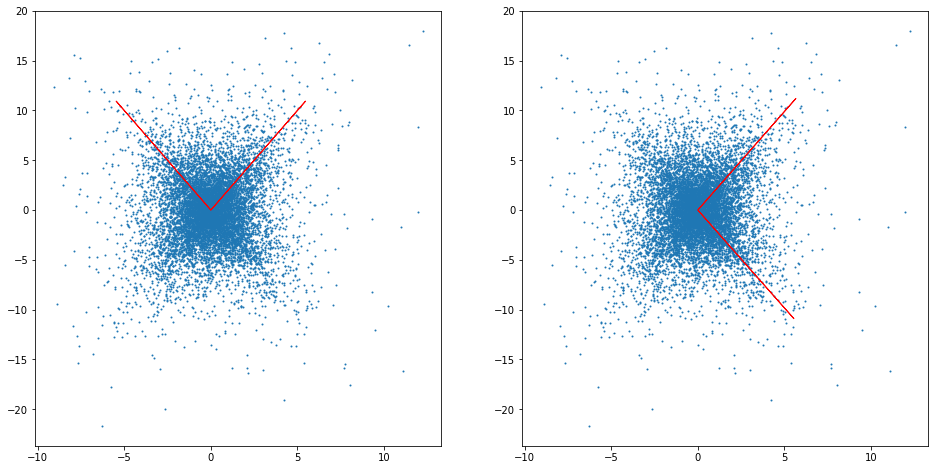

In [9]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)
    
compareMixingMatrix(synthData, verifyA, estimateA)

### Applying to Mixed Sound Tracks

Now that we know the algorithm is accurate, we can apply it to the mixed sound tracks we generated earlier and write the separated tracks to their respective audio files:

gradient norm:  20311.76524743754
mixing matrix:  [[1169.01979078  856.68665956]
 [1104.60482676  899.52322565]]
gradient norm:  1752.1237028770836
mixing matrix:  [[ 9637.70553483 -3277.35855055]
 [ 8007.39976272  -294.03133612]]
gradient norm:  219.96621190502816
mixing matrix:  [[10588.84488743 -3823.94712181]
 [ 8847.00465135  -471.02672705]]


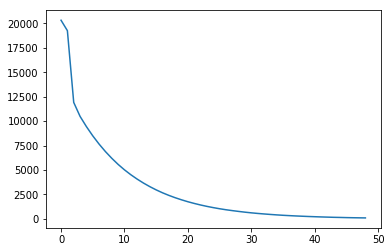

In [10]:
A, S = bss(X)

In [11]:
# normalized sound tracks
S = audionorm(S)
# write recovered sound track into WAV files
wavfile.write('data/separatedTrackA.wav', 22050, S[0])
wavfile.write('data/separatedTrackB.wav', 22050, S[1])

### Evaluating the Results

We can then compare our estimated mixing matrix to the ground truth:

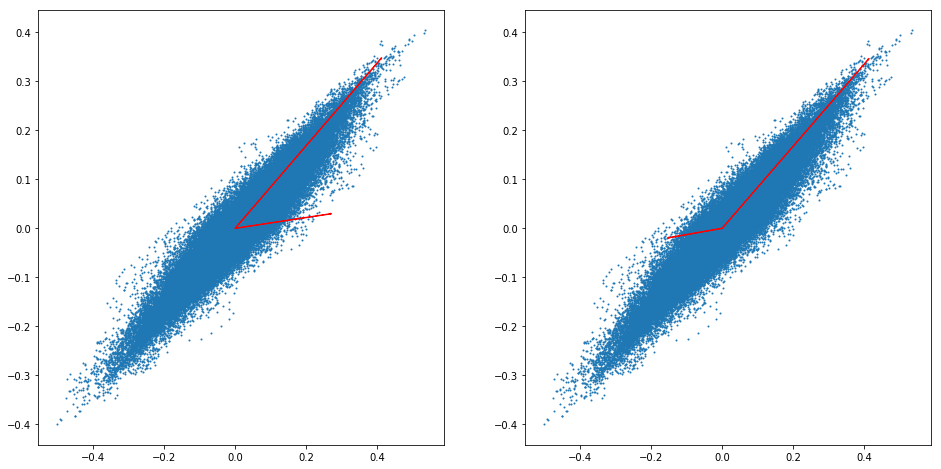

In [12]:
compareMixingMatrix(X, gtruthA, A)

In [13]:
print('\nMixing Matrix (Our Estimation)\n\n', A)
print('\nMixing Matrix (Groud Truth)\n\n', gtruthA)


Mixing Matrix (Our Estimation)

 [[10655.49074623 -3881.49485639]
 [ 8911.90116721  -497.17160575]]

Mixing Matrix (Groud Truth)

 [[0.94276302 0.61511149]
 [0.79401569 0.06758983]]


Notice how our mixing matrix estimation is drastically different from the ground truth.  Notice, though, that the basis vectors are simply flipped, meaning that although they numerically appear very different, the coordinate axes representing our data transformation are still equivalent and so the mixing matrix will yield the same result as with the ground truth.

TODO: try sampling from original sound track data to make it run more quickly, see how few samples you can take